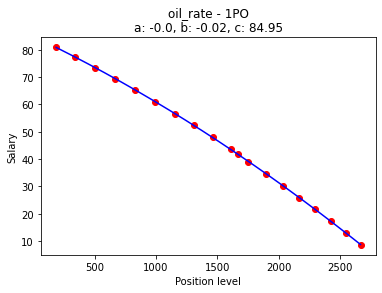

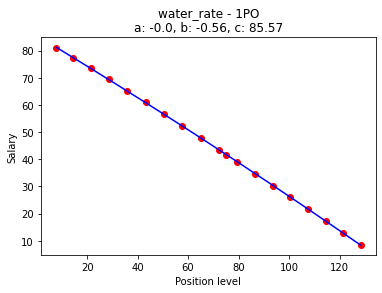

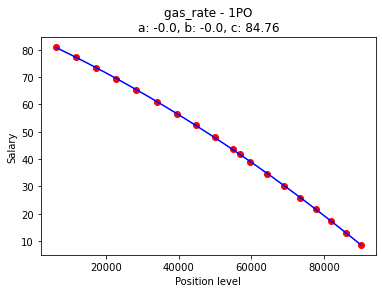

,well,a_oil,b_oil,c_oil,a_wat,b_wat,c_wat,a_gas,b_gas,c_gas,PI_oil,PI_wat,PI_gas
0,1PO,-2.680078e-06,-0.021424,84.945385,-0.000331,-0.558887,85.574703,-2.641155e-09,-0.000607,84.760584,36.613397,1.671321,1245.468441
1,3PO,-2.471364e-04,-0.214081,204.418948,-0.000144,-0.507123,207.679053,-1.555572e-07,-0.005371,204.418948,3.867258,2.209905,154.143951
2,8PO,-1.803075e-06,-0.062644,208.831695,-0.002255,-1.466831,207.661541,-1.134925e-09,-0.001572,208.831695,20.922718,0.857034,833.952655
3,1021G,-4.467358e-07,-0.009108,86.615424,-0.000062,-0.230417,88.475904,-5.400074e-10,-0.000244,86.098496,89.345518,4.037153,3022.789452
4,1011G,-1.249638e-07,-0.003222,94.163503,-0.000012,-0.115066,96.140472,-1.580164e-10,-0.000063,92.597749,227.496065,8.888198,8162.259764
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1115,-4.698590e-07,-0.014023,196.461912,-0.000090,-0.127080,194.117009,-2.980779e-10,-0.000351,196.415611,85.296179,7.901950,3399.448392
115,1116,-3.666860e-05,-0.162589,200.894189,-0.002453,-0.955774,199.709479,-2.308063e-08,-0.004079,200.894189,7.186751,1.109343,286.454674
116,1117,-1.213510e-06,-0.038968,205.225176,-0.000230,-0.347443,203.879767,-7.638302e-10,-0.000978,205.225176,32.616977,3.300395,1300.070783
117,1118,-1.858400e-05,-0.186336,210.825370,-0.023173,-4.349034,209.983768,-1.169749e-08,-0.004675,210.825370,6.697250,0.267681,266.943776


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


def get_data(filename):
    # загружаем данные
    df = pd.read_csv (filename, sep="\t",)

    # меняем названия колонок
    col_names=['well', 'dates', 'BHP', 'oil_rate', 'water_rate','gas_rate', 'mas_oil_rate','mas_gas_rate','PI_oil', 'PI_water','PI_gas']
    df.columns = col_names

    #преобразуем тип данных
    df.iloc[:, 2:10] = df.iloc[:, 2:10].astype(float)

    # удаляем выбросы
    df = df[df['oil_rate']>=0.9]
    
    return df
    
# полиномиальная регрессия
def get_reg_coeffs(df_temp, word, N_set_graphs, well):
    X = df_temp[word].values.reshape(-1, 1)
    y = df_temp['BHP'].values
     
    coefs = np.polyfit(X.flatten(), y, 2)    
    
    # Построение полинома
    if N_set_graphs>0:
        poly_reg = PolynomialFeatures(degree=2)
        X_poly = poly_reg.fit_transform(X)
        lin_reg2 = LinearRegression()
        lin_reg2.fit(X_poly,y)

        X_grid = np.arange(min(X),max(X),0.1)
        X_grid = X_grid.reshape(len(X_grid),1) 
        plt.scatter(X,y, color='red') 

        plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue')

        plt.title(f"{word} - {well}\n{''', '''.join(list(map(lambda x: f'{x[0]}: {str(round(x[1], 2))}', zip(['a','b','c'], coefs))))}")
        plt.xlabel('Position level')
        plt.ylabel('Salary')
        plt.show()
    
    return coefs

# итерируемся по уникальным названиям скважин

def get_new_PI(df_temp, word):
    PI = df_temp[word].values.reshape(-1,1)
    PI=sum(PI)/len(PI)
    
    return PI


def get_ipr_data(path, path_save, N_set_graphs):
    
    df = get_data(path)
    result = pd.DataFrame(columns=['well','a_oil','b_oil','c_oil','a_wat','b_wat','c_wat','a_gas','b_gas','c_gas','PI_oil','PI_wat','PI_gas'])
    wells = df['well'].unique()
    for well in wells[0:]:
        
        df_temp = df[df['well']==well]
        a_oil, b_oil, c_oil = get_reg_coeffs(df_temp, 'oil_rate', N_set_graphs, well)
        a_wat, b_wat, c_wat = get_reg_coeffs(df_temp, 'water_rate', N_set_graphs, well)
        a_gas, b_gas, c_gas = get_reg_coeffs(df_temp, 'gas_rate', N_set_graphs, well)
        
        
        PI_oil=get_new_PI(df_temp,'PI_oil')
        PI_wat=get_new_PI(df_temp,'PI_water')
        PI_gas = get_new_PI(df_temp,'PI_gas')
        
        result = result.append({'well': well, 'a_oil':a_oil, 'b_oil':b_oil, 'c_oil':c_oil, 'a_wat':a_wat, 'b_wat':b_wat, 'c_wat':c_wat,
                            'a_gas':a_gas, 'b_gas':b_gas, 'c_gas':c_gas, 'PI_oil':float(PI_oil), 'PI_wat':float(PI_wat), 
                                'PI_gas':float(PI_gas)}, ignore_index=True)
        N_set_graphs-=1
    
    result.to_csv(path_save, sep = '\t', index = False)
    
    return result


N_set_graphs = 1

path      = r'/Users/marchhelena/Desktop/Python/IPR_point.txt'
path_save = r'/Users/marchhelena/Desktop/Python/Result.txt'
result = get_ipr_data(path, path_save, N_set_graphs)
display(result)